<a href="https://colab.research.google.com/github/ronocara/Netflix-Show-Recommendation/blob/main/Netflix_ShowRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CS2170 Final Project
# lenz Baron Balita and Cara L. Roño


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.tools.tools as stattools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import random

!pip install pyLDAvis
#topic modeling
import nltk
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.util import ngrams
import nltk, re, string, gensim
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict
from gensim import corpora
from nltk.stem import SnowballStemmer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 14.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## **I. Data Gathering**

the dataset that will be used in this study is sourced from Kaggle. The dataset is about Netflix movies and TV shows. 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS170 Project/netflix_titles.csv')
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [5]:
df.shape

(7787, 12)

#**II. Data Cleaning**

In [6]:
# checking data types of fields
df.dtypes

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

In [7]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [8]:
# Dropping irrelevant columns.
df = df.drop(['show_id'], axis=1)
df.head(2)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


In [9]:
# renaming some column names. 
df = df.rename(columns={"listed_in":"genre"})
df.columns

Index(['type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'genre', 'description'],
      dtype='object')

In [10]:
# splitting the dataset between Movies and TV shows
netflix_movies = df[df['type'] == 'Movie']
netflix_shows = df[df['type'] == 'TV Show']

In [11]:
#checking duplicate rows
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 11)


In [12]:
#checking null columns
print(df.isnull().sum())

type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
genre              0
description        0
dtype: int64


In [13]:
#replacing null values with 'not specified'

df.fillna('Not specified')
df.replace(np.nan, ' none')

,type,title,director,cast,country,date_added,release_year,rating,duration,genre,description
0,TV Show,3%,none,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...
7782,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,Movie,Zulu Man in Japan,none,Nasty C,none,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,TV Show,Zumbo's Just Desserts,none,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


In [14]:
#standardizing numeric field 'release_year'
from scipy import stats
df['release_year_z']= stats.zscore(df['release_year'])
df['release_year_z']

0       0.692878
1       0.236092
2      -0.334890
3      -0.563284
4      -0.677480
          ...   
7782   -1.020070
7783    0.121896
7784    0.578682
7785    0.578682
7786    0.578682
Name: release_year_z, Length: 7787, dtype: float64

In [15]:
# detecting outliers z-values wither greater than 3 or less than -3. 
outliers = df.query('release_year_z>3 | release_year<-3')
outliers

,type,title,director,cast,country,date_added,release_year,rating,duration,genre,description,release_year_z


# **III. Exploratory Data Analysis**

General Question: How would people answer if they were to guess the genre(s) for the same movie/tv show?

    Will they have the same answers?
    Will we be able to assign a genre based on the description?
    If there is a new movie, can they predict the topic probablity?


Text(0.5, 1.0, 'Distribution of Movie/TV Show')

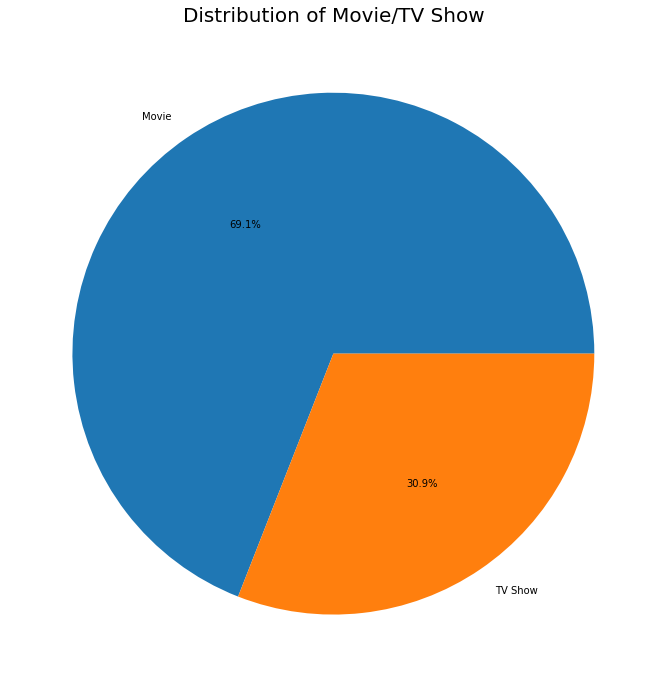

In [16]:
# Distribution of Movies/Shows
bar, ax = plt.subplots(figsize = (12,12))
plt.pie(df['type'].value_counts(), labels = df['type'].value_counts().index, autopct="%.1f%%")
plt.title('Distribution of Movie/TV Show', size=20)

Text(0.5, 1.0, 'Release Frequency over Years')

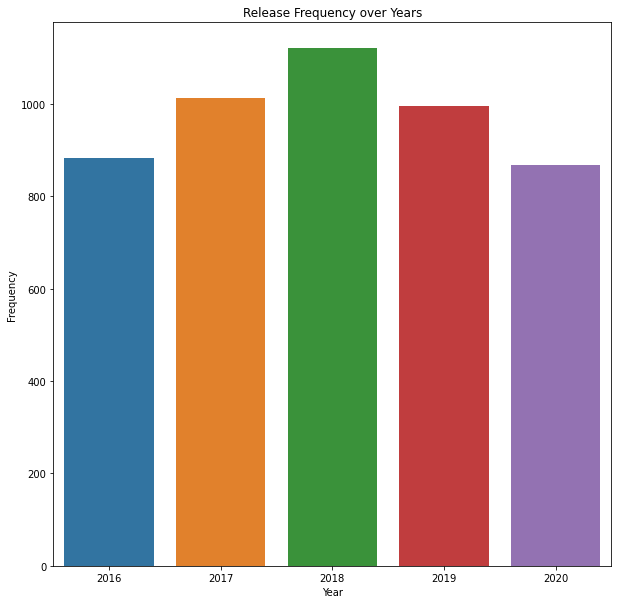

In [17]:
bar, ax = plt.subplots(figsize = (10,10))
sns.barplot(x = df['release_year'].value_counts().index[:5], y = df['release_year'].value_counts()[:5])
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Release Frequency over Years')

In [18]:
#Growth of Movie/Show over the years
movie_data = df[df['type'] == 'Movie']
tv_show_data = df[df['type'] == 'TV Show']
temp = df[['type', 'release_year']]
temp = temp.value_counts().to_frame()
temp.reset_index(level=[0,1], inplace=True)
temp = temp.rename(columns = {0:'count'})
temp = pd.concat([temp[temp['type'] == 'Movie'][:5], temp[temp['type']== 'TV Show'][:5]])

Text(0.5, 1.0, 'Growth of Movie/TV Show over Years')

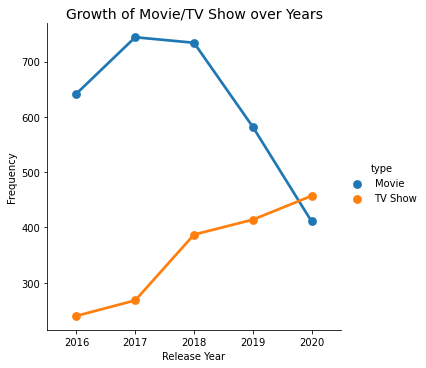

In [19]:
sns.catplot(x = 'release_year', y = 'count', hue = 'type', data = temp, kind = 'point')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.title('Growth of Movie/TV Show over Years', size=14)

<AxesSubplot:title={'center':'Top 10 countries that produced most movies'}>

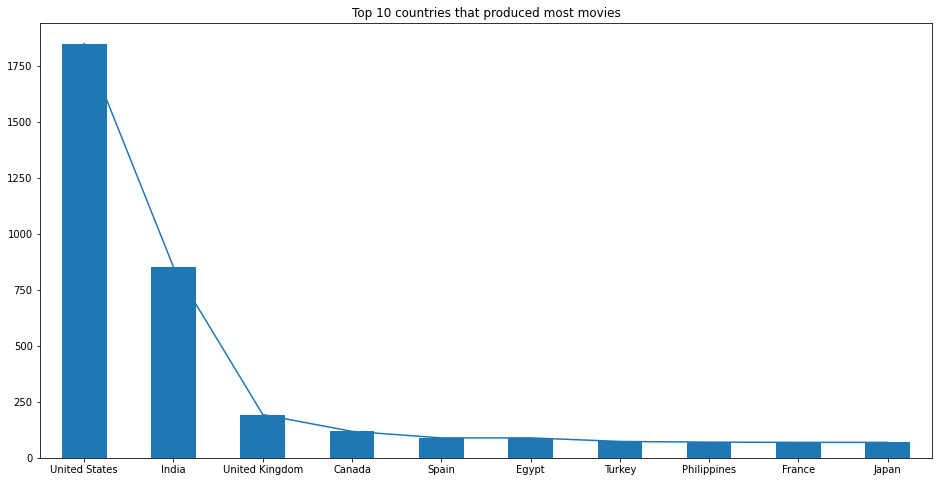

In [20]:
#Top 10 countries that produced most movies in Netflix
histo1= netflix_movies.country.value_counts().head(10)
histo1.plot(kind='bar')
plt.title('Top 10 countries that produced most movies')
histo1.plot(figsize=(16,8))


<AxesSubplot:title={'center':'Top 10 countries that produced most TV shows'}>

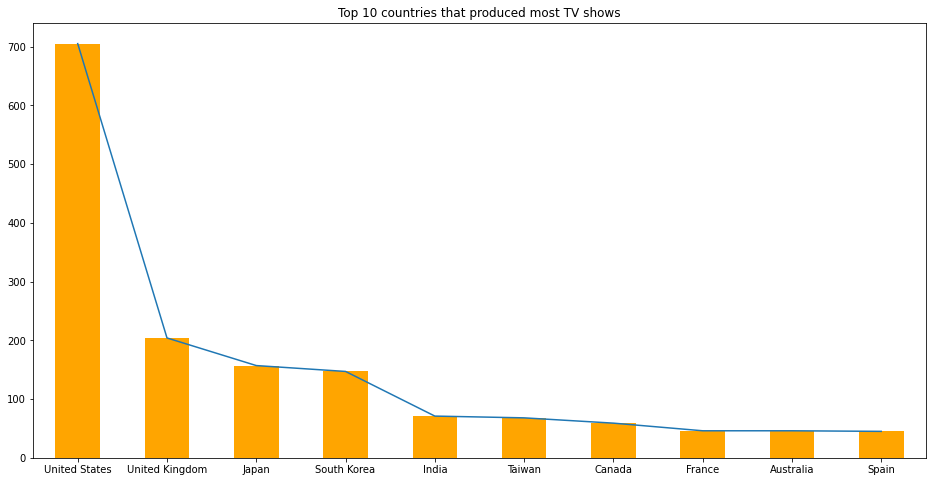

In [21]:
#Top 10 countries that produced most TV shows in Netflix

histo2=netflix_shows.country.value_counts().head(10)
histo2.plot(kind='bar', color='orange')
plt.title('Top 10 countries that produced most TV shows')
histo2.plot(figsize=(16,8))

<AxesSubplot:>

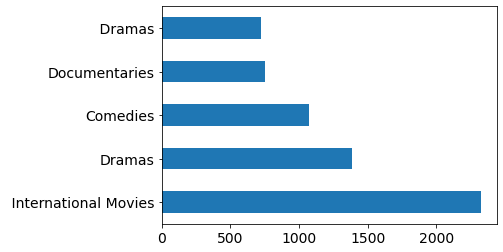

In [22]:
# top genres in Netflix

#filling null values 
df['genre']=df['genre'].fillna('Not Specified')
#Splitting multiple genres. 
FGenre=pd.DataFrame()
FGenre=df['genre'].str.split(',', expand=True).stack()
FGenre=FGenre.to_frame()
FGenre.columns=['Genre']
#grouping different genres and getting total content
genres=FGenre.groupby(['Genre']).size().reset_index(name='Total Content')
genres=genres[genres.Genre !='Not Specified']
genres=genres.sort_values(by=['Total Content'],ascending=False)
genres=genres.head()
#plotting bar chart
genres=FGenre.Genre.value_counts().head(5)
genres.plot(kind="barh", fontsize=14)

# RECOMMENDATIONS


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class ContentAnalysis():
    def __init__(self, data_frame, threshold = 0.1, stop_words = 'english', lowercase = True, use_idf = True, norm=u'l2', smooth_idf = True):
        self.data_frame = data_frame
        self.model = TfidfVectorizer(max_df=threshold,stop_words=stop_words, lowercase=lowercase, use_idf=use_idf,norm=norm,smooth_idf=smooth_idf)
        self.vector = False

    def generate_vector(self, data):
        self.vector = self.model.fit_transform(data)
    

    def find_movies(self, request, top = 10):
        if self.vector is not False:
            content_transformation = self.model.transform([request])
            movie_relatively = np.array(np.dot(content_transformation,np.transpose(self.vector)).toarray()[0])
            index = np.argsort(movie_relatively)[-top:][::-1]
            rate = [movie_relatively[i] for i in index]
            result = zip(index, rate)     
            self.render_result(request, result)
            

    def recommend_movie(self, request_index , top = 15):
        if self.vector is not False:
            cosine_similarity = linear_kernel(self.vector[request_index:request_index+1], self.vector).flatten()
            index = cosine_similarity.argsort()[-top-1:-1][::-1]
            rate = [cosine_similarity[i] for i in index]
            result = zip(index, rate)     
            self.render_result(str(self.data_frame[request_index:request_index+1]), result)

    def render_result(self, request_content,indices):
        print('Your request : ' + request_content)
        print('----------------------------------')
        print('Best Results :')
        data = self.data_frame
        for index, rate in indices:
            print('Confidence: {:.2f}%, {}'.format(rate*100, data['title'].loc[index] ))

In [24]:
#Recommends movie based on description and grabs the similarity as its results
vector = ContentAnalysis(df)
vector.generate_vector(df["description"])
vector.recommend_movie(100)

Your request :       type     title         director  \
100  Movie  3 Idiots  Rajkumar Hirani   

                                                  cast country  \
100  Aamir Khan, Kareena Kapoor, Madhavan, Sharman ...   India   

         date_added  release_year rating duration  \
100  August 1, 2019          2009  PG-13  164 min   

                                      genre  \
100  Comedies, Dramas, International Movies   

                                           description  release_year_z  
100  While attending one of India's premier college...       -0.563284  
----------------------------------
Best Results :
Confidence: 23.19%, College Romance
Confidence: 17.27%, Engineering Girls
Confidence: 15.25%, Candy Jar
Confidence: 15.13%, Mr. Young
Confidence: 14.78%, 100 Things to do Before High School
Confidence: 14.70%, Pahuna
Confidence: 14.66%, Best Neighbors
Confidence: 13.64%, Be with Me
Confidence: 13.47%, Moms at War
Confidence: 12.88%, Lovesong
Confidence: 12.67%, Limitle

In [25]:
vector = ContentAnalysis(df)
vector.generate_vector(df["title"])
vector.find_movies('Happy Birthday')

Your request : Happy Birthday
----------------------------------
Best Results :
Confidence: 62.52%, My Birthday Song
Confidence: 59.06%, Happy And
Confidence: 59.06%, Almost Happy
Confidence: 59.06%, Happy!
Confidence: 42.85%, My Happy Family
Confidence: 37.23%, Merry Happy Whatever
Confidence: 37.23%, Happy Go Lucky
Confidence: 37.23%, Happy Hunting
Confidence: 37.23%, Happy Times
Confidence: 36.64%, Happy Valley


# **IV. Modeling**

TOPIC MODELING - This creates topics/groups based on descriptions.

training LDA model that is based on the title's descriptions and used to determine the topic of unseen description

In [27]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [28]:
ps = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer() 

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


#Words from corpus - dictionary 
words = set(nltk.corpus.words.words())


#Text cleaning - tokenization, remove special characters, punctions, meaningless words etc.
def txt_clean(txt):
    tokens = nltk.word_tokenize(txt.lower())
    tokens_clean = [w for w in tokens if w.isalpha() and w in words] 
    return tokens_clean

#create unigram/bigram/trigram words, remove stopwords, lemmatize
def lemmatize_stem(tokens, ngram_type=None):
    
    bigram = gensim.models.Phrases(tokens, min_count=2, threshold=100)
    bigram_tokens = [bigram[tokens[w]] for w in range(len(tokens))]
    trigram = gensim.models.Phrases(bigram[tokens],threshold=100)
    trigram_tokens = [trigram[tokens[w]] for w in range(len(tokens))]
    
    tokens_clean = []
    if ngram_type == "bigram":
        tokens_c = bigram_tokens
    elif ngram_type == "trigram":
        tokens_c = trigram_tokens
    else:
        tokens_c = tokens

    for i in range(len(tokens)-1):
        txt = tokens_c[i]
        txt_above5 = [k for k in txt if len(k)>=5 and k not in gensim.parsing.preprocessing.STOPWORDS]
        lemma_txt = [lemmatizer.lemmatize(w,pos=tag_map[tg[0]]) for w,tg in nltk.pos_tag(txt_above5)]
        stem_txt = [w for w in lemma_txt]
        tokens_clean.append(stem_txt)

    dictionary = corpora.Dictionary(tokens_clean)
    corpus = [dictionary.doc2bow(text) for text in tokens_clean]
    
    return dictionary, corpus, tokens_clean

unseen_len = int(round(0.10 * len(df),0))
unseen_data = df["description"].sample(unseen_len) #random sample
txt_data = df["description"].drop(unseen_data.index)

#Tokenize and clean
tokens = list(txt_data.apply(lambda x: txt_clean(x)))

#Chose bigram - it had the best performace (tried both unigram and trigram)
dictionary, corpus, tokens_clean = lemmatize_stem(tokens, "bigram")

from gensim.models import CoherenceModel

#Choosing best parameter and topics
topics_arr = [20, 40, 60, 80]
learning_decay = [0.5, 0.7, 0.9]
minimum_probability= [0.01, 0.05, 0.08]

def best_params(topic_num, min_probability, decay):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word=dictionary, passes=15, minimum_probability=min_probability, decay=decay)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=ldamodel, texts = tokens_clean, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return [topic_num, min_probability, decay, coherence_lda]
print("finished picking best parameter")

#Parameter Tuning - this'll take some time to run
params = []
for t in topics_arr:
    for p in minimum_probability:
        for l in learning_decay:
            val = best_params(t,p,l)
            params.append(val)
print("finished tuning parameter")

#Chosen from the above function (The number of topics and decay shouldn't be too high or too low)
topic_num = 40
min_probability = 0.05
learning_decay = 0.5


ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = topic_num, id2word=dictionary, passes=15, minimum_probability=min_probability, decay=learning_decay)
print("\nSample of Topics:")
for i,j in ldamodel.show_topics(formatted=True,num_words= 10):
    print("Topic-{} => {}".format(i,j))
topics = ldamodel.print_topics(num_words=10)



/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


finished picking best parameter
finished tuning parameter

Sample of Topics:
Topic-17 => 0.062*"secret" + 0.054*"agent" + 0.050*"criminal" + 0.038*"romantic" + 0.033*"aspire" + 0.019*"family" + 0.018*"confront" + 0.017*"successful" + 0.014*"grieve" + 0.014*"player"
Topic-35 => 0.046*"deadly" + 0.031*"elite" + 0.030*"lose" + 0.025*"group" + 0.024*"wrong" + 0.024*"extreme" + 0.022*"collection" + 0.022*"uncover" + 0.022*"world" + 0.018*"attack"
Topic-5 => 0.070*"history" + 0.032*"south" + 0.032*"family" + 0.028*"control" + 0.028*"artist" + 0.024*"empire" + 0.023*"footage" + 0.023*"trap" + 0.022*"vacation" + 0.021*"tragic"
Topic-30 => 0.047*"street" + 0.043*"magical" + 0.039*"prison" + 0.024*"miss" + 0.023*"undercover" + 0.022*"entangle" + 0.021*"final" + 0.019*"party" + 0.018*"coach" + 0.015*"mission"
Topic-37 => 0.056*"turn" + 0.045*"live" + 0.032*"young" + 0.030*"navigate" + 0.027*"widow" + 0.025*"world" + 0.022*"family" + 0.019*"international" + 0.017*"model" + 0.017*"classmate"
Topic-

In [29]:
#Description-topic distributions for our training set  - It lists top 4 keywords and Dominant topic for each sentence
arr = []
for i, j in enumerate(ldamodel[corpus]):
    if len(j) > 0:
        max_val = sorted([w[1] for w in j],reverse=True)[0]
        max_topic = [w[0] for w in j if w[1]==max_val][0]
        keywords = ldamodel.show_topic(max_topic,topn=4)
        keywords = [k[0] for k in keywords]
        description = txt_data.iloc[i]
        arr.append([description,  ",".join(keywords), max_topic, round(max_val,2),])

lda_distribution = pd.DataFrame(arr, columns=['Description', 'Top Keywords', 'Dominant Topic', 'Probability'])
lda_distribution.head()

,Description,Top Keywords,Dominant Topic,Probability
0,In a future where the elite inhabit an island ...,"brother,career,train,local",28,0.38
1,After a devastating earthquake hits Mexico Cit...,"relationship,rescue,attempt,fight",10,0.29
2,"When an army recruit is found dead, his fellow...","secret,agent,criminal,romantic",17,0.27
3,A brilliant group of students become card-coun...,"stage,quest,inside,humanity",18,0.58
4,A genetics professor experiments with a treatm...,"secret,agent,criminal,romantic",17,0.60


In [30]:
#predicting topics for unseen data
unseen_clean = unseen_data.apply(lambda x: txt_clean(x))
    
arr = []
for i in unseen_clean:
    lemma_txt = [lemmatizer.lemmatize(w,pos=tag_map[tg[0]]) for w,tg in nltk.pos_tag(i)]
    lemma_txt2 = [w for w in lemma_txt if w not in gensim.parsing.preprocessing.STOPWORDS]
    arr2 = ldamodel[dictionary.doc2bow(lemma_txt2)]
    max_arr2 = sorted([x[1] for x in arr2],reverse=True)[:3]
    sel_arr2 = [list(x) for x in arr2 if x[1] in max_arr2][:3]
    sel_arr2 = sum(sel_arr2,[])
    if len(sel_arr2) != 6:
        sel_arr2.extend(["None"]*(6-len(sel_arr2)))
    
    sel_arr2.extend([i])
    arr.append(sel_arr2)

unseen_df = pd.DataFrame(arr, columns = ["topic_1", "topic_1_prob", "topic_2", "topic_2_prob", "topic_3", "topic_3_prob", 'Tokens']).round(2)
unseen_df["Description"] = list(unseen_data)
cols = list(unseen_df.columns)
cols = cols[-1:] + [cols[-2]] + cols[:-2]
unseen_df = unseen_df[cols]
unseen_df.head()

,Description,Tokens,topic_1,topic_1_prob,topic_2,topic_2_prob,topic_3,topic_3_prob
0,"Risking his family and future, a banker in occ...","[his, family, and, future, a, banker, in, slow...",15,0.15,27,0.135476,32,0.137516
1,The adorable Best Popple Pals love helping the...,"[the, adorable, best, popple, love, helping, t...",6,0.15,9,0.146429,16,0.146429
2,The first lady of Mexico is a woman of convict...,"[the, first, lady, of, is, a, woman, of, convi...",4,0.10,9,0.1025,22,0.1025
3,"Recruited by a sheriff, volunteers infiltrate ...","[by, a, sheriff, infiltrate, county, to, expos...",8,0.15,19,0.286883,22,0.146429
4,Courtroom intrigue plays out against a backdro...,"[courtroom, intrigue, out, against, a, backdro...",1,0.11,3,0.113889,5,0.113889


##Model Evaluation


In [31]:
#Perplexity - how probable where some of the new unseen data that were given to the model that was learned earlier.
print('Perplexity: ', ldamodel.log_perplexity(corpus))

Perplexity:  -9.037096479462475


In [32]:
#Coherence - measure the degree of semantic similarity between high scoring words in each topic (and then average across topics)
coherence_model_lda = CoherenceModel(model=ldamodel, texts = tokens_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.5718469485090405


# **V. Evaluation (Interpreting Results)**




In [33]:
#Clustering each movie/show per genre

#adding genre column in lds_distribution table
genres = pd.DataFrame(df['genre'])
LDA = pd.DataFrame(lda_distribution)
LDA = LDA.join(genres)
LDA.head()

,Description,Top Keywords,Dominant Topic,Probability,genre
0,In a future where the elite inhabit an island ...,"brother,career,train,local",28,0.38,"International TV Shows, TV Dramas, TV Sci-Fi &..."
1,After a devastating earthquake hits Mexico Cit...,"relationship,rescue,attempt,fight",10,0.29,"Dramas, International Movies"
2,"When an army recruit is found dead, his fellow...","secret,agent,criminal,romantic",17,0.27,"Horror Movies, International Movies"
3,A brilliant group of students become card-coun...,"stage,quest,inside,humanity",18,0.58,"Action & Adventure, Independent Movies, Sci-Fi..."
4,A genetics professor experiments with a treatm...,"secret,agent,criminal,romantic",17,0.60,Dramas


In [34]:
FGenre = pd.DataFrame(LDA['genre'])
FGenre=LDA['genre'].str.split(',', expand=True)
FGenre=FGenre[0]
FGenre=FGenre.to_frame()
FGenre.columns=['genre']



In [35]:
#sort by genres. 
GenresGrouped=LDA.groupby(['genre'])


In [37]:
# getting top dominant topics per genre

DTopics=pd.DataFrame()
DTopics=LDA['Dominant_Topic']
DTopics=DTopics.to_frame()
DTopics.columns=['Dominant_Topic']
#joining two data frames
TTopics=DTopics.groupby(['Dominant_Topic']).size().reset_index(name='Total Content')
TTopics=TTopics.sort_values(by=['Dominant_Topic'],ascending=False)
TTopics=TTopics.head()
#plotting bar chart
TTopics=DTopics.Dominant_Topic.value_counts().head(5)
TTopics.plot(kind="barh", fontsize=14, title='Top 5 Dominant topics')



KeyError: ignored

In [ ]:
#word cloud for top topics per 

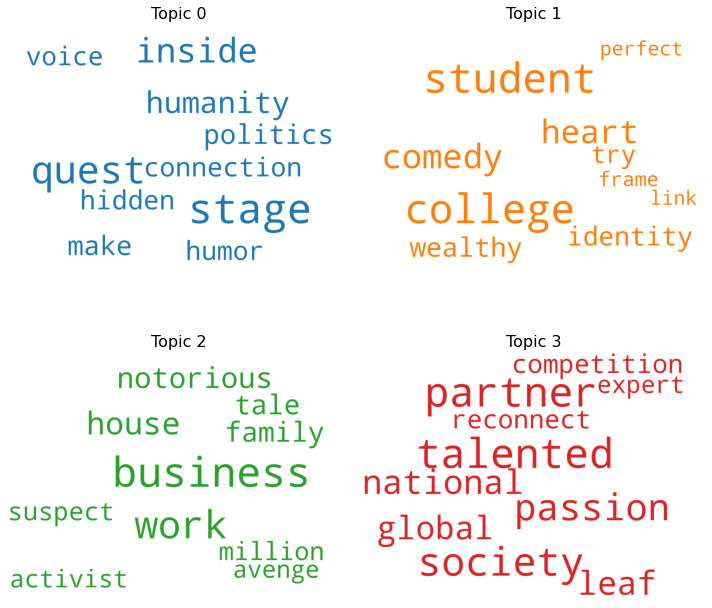

In [38]:
#word cloud of top Dminant topics 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)


fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [39]:
#top relevant terms 
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.117676 -0.055668       1        1  2.403472
1      0.002994  0.038157       2        1  2.209801
2     -0.037259 -0.007586       3        1  2.479692
3     -0.017821 -0.070693       4        1  2.056929
4     -0.045381 -0.038364       5        1  2.229230
5     -0.009097  0.155713       6        1  2.650042
6     -0.036722  0.085993       7        1  2.239160
7     -0.102303  0.103076       8        1  2.447938
8      0.240447 -0.012277       9        1  3.182434
9     -0.011529 -0.031946      10        1  2.439170
10    -0.099252  0.002245      11        1  2.466837
11     0.043289 -0.024082      12        1  2.691983
12     0.000575  0.009578      13        1  2.499462
13     0.024310 -0.028185      14        1  1.973975
14    -0.096660  0.092974      15        1  2.132523
15     0.071502  0.016976      16        1  2.170166
16    -0.102811  0.165945      17        1  2.951540
17    -0.016769 -0.011466      18        1  2.371548
18    -0.099650 -0.045082      19        1  2.360378
19     0.010167 -0.087471      20        1  2.497398
20    -0.039749  0.017505      21        1  2.335806
21    -0.093747 -0.043137      22        1  2.363797
22    -0.113999  0.054586      23        1  2.611130
23    -0.023665 -0.049570      24        1  2.620233
24     0.008971  0.000915      25        1  2.629308
25     0.134187  0.076886      26        1  3.057633
26     0.052091 -0.113998      27        1  2.283610
27    -0.004882  0.064675      28        1  2.699036
28     0.042672  0.121635      29        1  2.585990
29     0.014503  0.000196      30        1  2.462578
30    -0.006844 -0.090643      31        1  2.563620
31     0.018458 -0.143153      32        1  2.366286
32     0.099880 -0.023419      33        1  2.271294
33     0.042541  0.048695      34        1  2.645567
34     0.014661 -0.133653      35        1  2.308681
35    -0.052896 -0.049190      36        1  2.252829
36     0.028445  0.003682      37        1  2.773591
37     0.120253  0.018038      38        1  2.569387
38     0.236415  0.067373      39        1  3.637824
39    -0.077647 -0.085259      40        1  2.508121, topic_info=            Term        Freq       Total Category  logprob  loglift
217        woman  322.000000  322.000000  Default  30.0000  30.0000
113        young  525.000000  525.000000  Default  29.0000  29.0000
421       murder  141.000000  141.000000  Default  28.0000  28.0000
214       mother  146.000000  146.000000  Default  27.0000  27.0000
1100     special  142.000000  142.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
534       forest   10.422891   19.274377  Topic40  -4.7144   3.0709
182       series   23.758781  295.989183  Topic40  -3.8905   1.1633
605      brother   10.545201   84.755995  Topic40  -4.7028   1.6015
85    mysterious    9.126761  118.076472  Topic40  -4.8472   1.1255
772    adventure    8.717966   67.017993  Topic40  -4.8930   1.6461

[1757 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
401      13  0.947057  abandon
2270     20  0.238240  ability
2270     33  0.635306  ability
82       25  0.153976   aboard
82       40  0.769882   aboard
...     ...       ...      ...
113      37  0.003806    young
113      38  0.072310    young
113      39  0.300656    young
895       6  0.936589    youth
3687      8  0.900695   zombie

[2381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [40]:
#Will they have the same answers? - As seen here in this data set, every topic in each description ended up with different results.
unseen_df.head()

,Description,Tokens,topic_1,topic_1_prob,topic_2,topic_2_prob,topic_3,topic_3_prob
0,"Risking his family and future, a banker in occ...","[his, family, and, future, a, banker, in, slow...",15,0.15,27,0.135476,32,0.137516
1,The adorable Best Popple Pals love helping the...,"[the, adorable, best, popple, love, helping, t...",6,0.15,9,0.146429,16,0.146429
2,The first lady of Mexico is a woman of convict...,"[the, first, lady, of, is, a, woman, of, convi...",4,0.10,9,0.1025,22,0.1025
3,"Recruited by a sheriff, volunteers infiltrate ...","[by, a, sheriff, infiltrate, county, to, expos...",8,0.15,19,0.286883,22,0.146429
4,Courtroom intrigue plays out against a backdro...,"[courtroom, intrigue, out, against, a, backdro...",1,0.11,3,0.113889,5,0.113889
